## Wygeneruj dataset

In [89]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [90]:
import numpy as np
import pandas as pd
# from scipy.spatial.distance import cityblock
# from itertools import permutations

# Generowanie danych wejściowych
np.random.seed(42)
n_orders = 4
n_trucks = 1
n_stations = 10

# Zamówienia: lokalizacja i waga
df_orders = pd.DataFrame({
    "latitude": np.random.randn(n_orders) * 50,
    "longitude": np.random.randn(n_orders) * 50,
    "mass": np.random.rand(n_orders) * 10
})

# Stacje benzynowe: lokalizacja i cena za litr
df_stations = pd.DataFrame({
    "latitude": np.random.randn(n_stations + 2) * 50,
    "longitude": np.random.randn(n_stations + 2) * 50,
    "price": np.random.rand(n_stations + 2) * 2 + 5
})

# Parametry
fuel_consumption = lambda m: m/100  # Spalanie na 100km w zależności od masy
fuel_tank_capacity = 150  # Pojemność baku
base_location = np.array([0, 0])  # Lokalizacja bazy
# average_speed = 40  # Średnia prędkość w km/h
# driver_hourly_rate = 50  # Godzinna stawka kierowcy

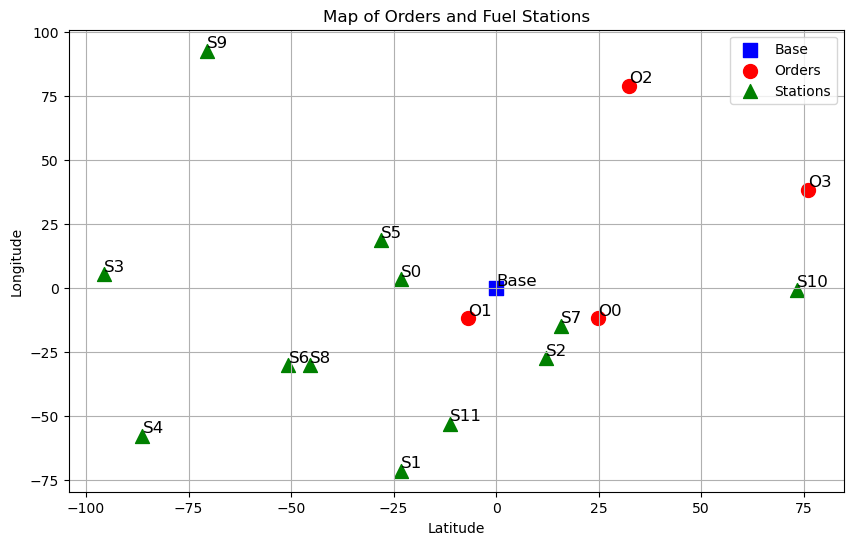

In [91]:
import matplotlib.pyplot as plt
# import pandas as pd

# Adding index as labels

# Plot orders and stations on a map
plt.figure(figsize=(10, 6))

# Plot base location
plt.scatter(base_location[0], base_location[1], c='blue', label='Base', s=100, marker='s')
plt.text(base_location[0], base_location[1], 'Base', fontsize=12, verticalalignment='bottom')

# Plot orders
plt.scatter(df_orders['latitude'], df_orders['longitude'], c='red', label='Orders', s=100, marker='o')
for i, row in df_orders.iterrows():
    plt.text(row['latitude'], row['longitude'], f'O{row.name}', fontsize=12, verticalalignment='bottom')
    
# Plot stations
plt.scatter(df_stations['latitude'], df_stations['longitude'], c='green', label='Stations', s=100, marker='^')
for i, row in df_stations.iterrows():
    plt.text(row['latitude'], row['longitude'], f'S{row.name}', fontsize=12, verticalalignment='bottom')

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Map of Orders and Fuel Stations')
plt.legend()
plt.grid(True)
plt.show()


In [92]:
import string

# Generate a list of letters
letter_index = list(string.ascii_uppercase[:len(df_orders)])
df_orders.index = letter_index

# print(df_orders.loc['C'])

df_orders.head()


,latitude,longitude,mass
A,24.835708,-11.707669,0.205845
B,-6.913215,-11.706848,9.699099
C,32.384427,78.960641,8.324426
D,76.151493,38.371736,2.123391


In [93]:
df_orders.loc['A', 'longitude']


-11.707668736166799

In [94]:
df_stations.loc[0] = {'StationID': int(0), 'Latitude': float(0.0), 'Longitude': float(0.0)}
df_stations.loc[1] = {'StationID': 0, 'Latitude': 0.0, 'Longitude': 0.0}

df_stations.head()

,latitude,longitude,price
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,12.098114,-27.219136,5.517560
3,-95.664012,5.546129,6.325045
4,-86.245892,-57.549679,5.623422


## Generate starting population

In [95]:
import random
original_list = df_orders.index.tolist()
print(f"Permutacja: {original_list}")

population = []

population_size = 10

for i in range(population_size):
    sample = [0]
    random_permutation = random.sample(original_list, len(original_list))
    
    for i in range(len(random_permutation)):
        sample.append(random_permutation[i])
        
        if i != len(random_permutation)-1:
            if random.randint(0, 1) == 1:
                station_ID = random.randint(1, n_stations-1)
            else:
                station_ID = 1
    
            sample.append(station_ID)
    # print(sample)
    sample.append(0)
    population.append(sample)
    
for i in population:
    print(i)

Permutacja: ['A', 'B', 'C', 'D']
[0, 'B', 1, 'A', 2, 'C', 1, 'D', 0]
[0, 'C', 1, 'A', 7, 'B', 1, 'D', 0]
[0, 'C', 1, 'D', 9, 'B', 1, 'A', 0]
[0, 'B', 1, 'A', 6, 'D', 8, 'C', 0]
[0, 'A', 9, 'D', 4, 'B', 2, 'C', 0]
[0, 'A', 3, 'B', 1, 'C', 1, 'D', 0]
[0, 'D', 6, 'B', 9, 'A', 1, 'C', 0]
[0, 'B', 2, 'A', 6, 'C', 7, 'D', 0]
[0, 'D', 9, 'B', 1, 'A', 9, 'C', 0]
[0, 'A', 1, 'B', 1, 'D', 1, 'C', 0]


## Evaluate population

In [96]:
# # Mini przykład
# a = 3
# b = 'A'
# current_mass = 1

def evaluate_step(a, b, current_mass, fuel_level):

    fuel_penalty = 1000
    max_fuel = 150

    
    step_cost = 0
    
    # miasto - miasto
    if isinstance(a, str) & isinstance(b, str):
        # print("z miasta do miasta - bez stacji")
        
        distance = (abs(df_orders.loc[a, 'longitude'] - df_orders.loc[b, 'longitude']) + 
                    abs(df_orders.loc[a, 'latitude'] - df_orders.loc[b, 'latitude']))

        fuel_level = fuel_level - distance * fuel_consumption(current_mass)
        
        # print("fuel_level: ", fuel_level)
        
        if fuel_level < 0:
            step_cost += fuel_penalty
            print("LAWECIARZ NA MIEJSCU")
            
        current_mass += df_orders.loc[b, 'mass']
        # print(f"Załadowano {df_orders.loc[b, 'mass']} towaru. {current_mass} mamy razem na pace")
        
    elif isinstance(a, str):

        if b != 1:
            if b == 0:
                df_stations.loc[b, 'latitude'] = float(0)
                df_stations.loc[b, 'longitude'] = float(0)
                df_stations.loc[b, 'price'] = np.random.rand() * 2 + 5
    
            # print("z miasta na stację - dojeżdżam na stację")    

    
            distance = (abs(df_orders.loc[a, 'longitude'] - df_stations.loc[b, 'longitude']) + 
                        abs(df_orders.loc[a, 'latitude'] - df_stations.loc[b, 'latitude']))
            # print('distance: ', distance)
    
            fuel_level = fuel_level - distance * fuel_consumption(current_mass)
    
            # print("fuel_level: ", fuel_level)
    
            if fuel_level < 0:
                step_cost += fuel_penalty
                print("LAWECIARZ NA MIEJSCU")
    
            step_cost += df_stations.loc[b, 'price'] * (max_fuel - fuel_level)
    
            # print(f"Zatankowano {(max_fuel - fuel_level)} litrów za {df_stations.loc[b, 'price'] * (max_fuel - fuel_level)} złotych" )
    
            fuel_level = max_fuel
        
    else:
        # print("ze stacji do miasta")
        
        if a == 0:
            df_stations.loc[a, 'latitude'] = float(0)
            df_stations.loc[a, 'longitude'] = float(0)
        
        distance = (abs(df_stations.loc[a, 'longitude'] - df_orders.loc[b, 'longitude']) + 
                    abs(df_stations.loc[a, 'latitude'] - df_orders.loc[b, 'latitude']))

        fuel_level = fuel_level - distance * fuel_consumption(current_mass)
        
        # print("fuel_level: ", fuel_level)
        
        if fuel_level < 0:
            step_cost += fuel_penalty
            # print("LAWECIARZ NA MIEJSCU")
            
        current_mass += df_orders.loc[b, 'mass']
        # print(f"Załadowano {df_orders.loc[b, 'mass']} towaru. {current_mass} mamy razem na pace")

    return current_mass, fuel_level, step_cost

# evaluate_step(a, b, current_mass, 150)

In [97]:
# sample = [0, 'A', 1, 'B', 1, 'C', 0]


def evaluate_case(sample):
    total_cost = 0
    fuel_level = 150
    current_mass = 1
    
    # print(f"START FUEL: {fuel_level}")
    for i in range(len(sample)-1):
        
        if sample[i] == 1:
            current_mass, fuel_level, step_cost = evaluate_step(sample[i-1], sample[i+1], current_mass, fuel_level)
        else:
            current_mass, fuel_level, step_cost = evaluate_step(sample[i], sample[i+1], current_mass, fuel_level)
        
        total_cost += step_cost
        # print(f"total cost: {total_cost}")
    
    
    return total_cost
    
# evaluate_case(sample)

In [98]:
population_results= {'samples': population, 'costs': []}

for sample in population:
    population_results['costs'].append(evaluate_case(sample))
    print(f"{sample} results: {evaluate_case(sample)}")

# print(population_results['samples'][0], population_results['costs'][0])

[0, 'B', 1, 'A', 2, 'C', 1, 'D', 0] results: 409.5191971463835
[0, 'C', 1, 'A', 7, 'B', 1, 'D', 0] results: 344.3050774523124
[0, 'C', 1, 'D', 9, 'B', 1, 'A', 0] results: 400.266242981287
[0, 'B', 1, 'A', 6, 'D', 8, 'C', 0] results: 670.3449400215243
[0, 'A', 9, 'D', 4, 'B', 2, 'C', 0] results: 357.95413324705936
[0, 'A', 3, 'B', 1, 'C', 1, 'D', 0] results: 354.36573461864435
[0, 'D', 6, 'B', 9, 'A', 1, 'C', 0] results: 608.6555753882777
[0, 'B', 2, 'A', 6, 'C', 7, 'D', 0] results: 650.9999663272908
[0, 'D', 9, 'B', 1, 'A', 9, 'C', 0] results: 490.5076988904672
[0, 'A', 1, 'B', 1, 'D', 1, 'C', 0] results: 331.7643756540321


## Selection

In [113]:
def selection_tournament(population_results, k=2, n=10):
    # population_results - populacja podana w formie słownika z wartościami funkcji kosztu
    # parametr k - wielkość próbki (wielkość turnieju)
    # parametr n - liczba osobników do wyselekcjonowania
    selected_individuals = []
    population_size = len(population_results['samples'])

    for _ in range(n):
        # Losowo wybierz indeksy osobników do turnieju
        tournament_indices = random.sample(range(population_size), k)
        
        # Znajdź najlepszy osobnik w turnieju
        best_index = tournament_indices[0]
        for idx in tournament_indices:
            if population_results['costs'][idx] < population_results['costs'][best_index]:
                best_index = idx
        
        # Dodaj wybranego osobnika do listy wybranych osobników
        selected_individuals.append(population_results['samples'][best_index])
    
    return selected_individuals
    

In [104]:
import random

def selection_by_probability(population_results):
    n = len(population_results['samples'])
    selected_population = []
    
    max_cost = max(population_results['costs'])
    # print(f"max_cost: {max_cost}")
    min_cost = min(population_results['costs'])    
    # print(f"min_cost: {min_cost}")
    
    
    for i in range(n):
        # Calculate the decision probability

        # If max cost = 100, and cost = 1, then decision_probability = 0.99
        # If max cost = 100, and cost = 100, then decision_probability = 0
        decision_probability = 1 -  ( population_results['costs'][i] - min_cost ) / ( max_cost - min_cost)
        # print(f"decision_probability: {decision_probability}")
        
        # Generate a random number and decide based on the decision probability
        if random.random() < decision_probability:
            selected_population.append(population_results['samples'][i])
    
    return selected_population

# # Example usage
# population_results = {
#     'samples': ['sample1', 'sample2', 'sample3', 'sample4'],
#     'costs': [10, 20, 30, 40]
# }
# 
# selected = selection_by_probability(population_results)
# print(f"Selected for reproduction: {selected}")


In [115]:
print(len(population_results['samples']))

for i in range(len(population_results['samples'])):
    print(population_results['samples'][i], population_results['costs'][i])


print("\n\nPROBABILISTIC")
selected_population = selection_by_probability(population_results)
for i in selected_population:
    print(i)
# print(selected_population)

print("\n\nTOURNAMENT")

selected_population = selection_tournament(population_results, 2, 10)
for i in selected_population:
    print(i)
# print(selected_population)

10
[0, 'B', 1, 'A', 2, 'C', 1, 'D', 0] 374.22800198391224
[0, 'C', 1, 'A', 7, 'B', 1, 'D', 0] 333.0213773150283
[0, 'C', 1, 'D', 9, 'B', 1, 'A', 0] 381.3581411307994
[0, 'B', 1, 'A', 6, 'D', 8, 'C', 0] 681.6357415429735
[0, 'A', 9, 'D', 4, 'B', 2, 'C', 0] 395.95043780772494
[0, 'A', 3, 'B', 1, 'C', 1, 'D', 0] 324.98254875731016
[0, 'D', 6, 'B', 9, 'A', 1, 'C', 0] 526.4103138561713
[0, 'B', 2, 'A', 6, 'C', 7, 'D', 0] 566.592216085705
[0, 'D', 9, 'B', 1, 'A', 9, 'C', 0] 535.2121964236602
[0, 'A', 1, 'B', 1, 'D', 1, 'C', 0] 250.71713208326486


PROBABILISTIC
[0, 'B', 1, 'A', 2, 'C', 1, 'D', 0]
[0, 'C', 1, 'A', 7, 'B', 1, 'D', 0]
[0, 'A', 3, 'B', 1, 'C', 1, 'D', 0]
[0, 'D', 9, 'B', 1, 'A', 9, 'C', 0]
[0, 'A', 1, 'B', 1, 'D', 1, 'C', 0]


TOURNAMENT
[0, 'A', 3, 'B', 1, 'C', 1, 'D', 0]
[0, 'A', 3, 'B', 1, 'C', 1, 'D', 0]
[0, 'C', 1, 'A', 7, 'B', 1, 'D', 0]
[0, 'B', 1, 'A', 2, 'C', 1, 'D', 0]
[0, 'B', 1, 'A', 2, 'C', 1, 'D', 0]
[0, 'A', 1, 'B', 1, 'D', 1, 'C', 0]
[0, 'B', 2, 'A', 6, 'C', 7, '

## Cross-over



In [169]:
# WARNING  - MIN 2 STATIONS

def cross_over(parent1, parent2, random_crossover_point=True):
    # parent1, parent2 - osobniki do krzyżowania
    # Zwraca osobnika potomnego
    
    # Wybierz losowy punkt krzyżowania
    if random_crossover_point:
        crossover_point_1 = random.randint(1, len(parent1)-2)
        crossover_point_2 = random.randint(crossover_point_1 + 1, len(parent1) - 1)
    else:
        crossover_point_1 = 3
        crossover_point_2 = 5
    
    print(f"Cross-over points: {crossover_point_1}, {crossover_point_2}")
    
    child1 = parent1.copy()
    
    for i in range(len(parent1)):
        if i%2 != 0:
            if i >= crossover_point_1 and i <= crossover_point_2:
                print(f"\nZamiana na {i} miejscu")
                original_spot_value = child1[i]
                to_insert = parent2[i]
                print(f"to_insert: {to_insert}")
                
                taken_spot_index = child1.index(to_insert)
                taken_spot_value = child1[taken_spot_index]
                print(f"taken_spot_index: {taken_spot_index}, taken_spot_value: {taken_spot_value}")
                
                while taken_spot_index >= crossover_point_1 and taken_spot_index < crossover_point_2:
                    taken_spot_value = child1[taken_spot_index]
                    taken_spot_index = child1.index(taken_spot_value)
                    
                        
                        
                    print(f"taken_spot_index: {taken_spot_index}, taken_spot_value: {taken_spot_value}")
                    
                child1[taken_spot_index] = original_spot_value
                
                #TODO - between crossover points get stations from second parent
                
                child1[i] = to_insert
                
                print(f"child1: {child1}")
    return child1

# HARD PATH
# cross_over([0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0], [0, 6, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0], random_crossover_point=False)
# cross_over([0, 6, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0], [0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0],  random_crossover_point=False)

# HAPPY PATH
# cross_over([0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0], [0, 6, 0, 5, 0, 4, 0, 3, 0, 2, 0, 1, 0],  random_crossover_point=False)
# cross_over([0, 6, 0, 5, 0, 4, 0, 3, 0, 2, 0, 1, 0], [0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0],  random_crossover_point=False)



# cross_over([1, 2, 3, 4, 5, 6], [6, 1, 2, 3, 4, 5], random_crossover_point=False)
# cross_over([1, 2, 3, 4, 5, 6], [6, 5, 4, 3, 2, 1], random_crossover_point=False)

In [ ]:
# 6 | 1 2 | 3 4 5
# 1 | 2 3 | 4 5 6

## 6 | 1 2 | 3 4 5
# 6 | 2 x | 4

In [ ]:
# 1 | 2 3 | 4 5 6
# 6 | 1 2 | 3 4 5

# 3 | 1 2 | 4 5 6 - prawidłowy
# [3, 1, 2, 4, 5, 6]

In [102]:
# OGÓLNA STRATEGIA:
# - generowanie populacji - DONE
# - ocena populacji - DONE
# - selekcja
# - krzyżowanie
# - mutacja

